<a href="https://colab.research.google.com/github/100jy/voice_competition/blob/master/inception_resNetv2_melspec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#구글 드라이브 연동
# 클라우드 권한 획득
from google.colab import auth, drive
auth.authenticate_user()
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import tensorflow as tf
import keras
from tqdm import tqdm
from glob import glob
from scipy.io import wavfile
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, Callback
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K
from keras.regularizers import l2

Using TensorFlow backend.


In [ ]:
y_train = pd.read_csv('drive/My Drive/data/train_answer.csv',index_col=0)
y_train = y_train.values
y_train.shape

(100000, 30)

In [ ]:
x_train = pd.read_pickle('drive/My Drive/data/x_trian_mel-spectogram.pickle')
x_train = x_train.values

# Upscaling data

In [2]:
##normalize
def normalize(x):
  return (x - np.mean(x)) / np.std(x)

#upscaling data(120x120 -> 299x299x1)
def Upscaling(data, reshape_dim):
  import cv2
  resized_imgs = []

  for img in tqdm(data):
    resized_imgs.append(cv2.resize(img, (reshape_dim[0], reshape_dim[1])) )

  result = np.array(resized_imgs)

  return result

In [ ]:
x_nor = list((map(normalize,x_train)))
x_nor = np.array(x_nor)
x_train = x_nor.reshape(100000,126,-1,1)
x_train.shape

(100000, 126, 126)

In [ ]:
leng = int(100000/10)
tmp = Upscaling(x_train[:leng],(299,299,1))

100%|██████████| 10000/10000 [00:01<00:00, 6490.97it/s]


In [ ]:
tmp[0].shape

(299, 299)

Text(0.5, 1.0, 'original')

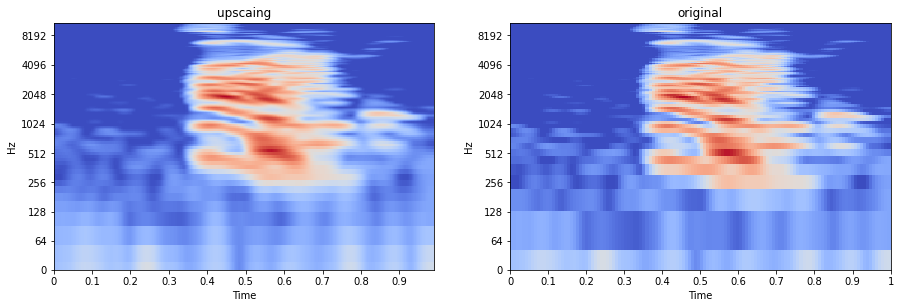

In [ ]:
import librosa
import librosa.display
plt.figure(figsize=(15,10))
plt.subplot(221)
hop_length = int(22050/299)
librosa.display.specshow(tmp[0], sr=22050, x_axis='time', y_axis='log',hop_length=hop_length, fmax=5000);
plt.title('upscaing')
plt.subplot(222)
hop_length = int(22050/126)
librosa.display.specshow(x_train[0], sr=22050, x_axis='time', y_axis='log',hop_length=hop_length, fmax=5000);
plt.title('original')

In [ ]:
#데이터 버킷에 저장
GCS_PATH = 'gs://data_bucket_9586/' 
AUTO = tf.data.experimental.AUTOTUNE # used in tf.data.Dataset API

record_num = 1000
file_num = x_train.shape[0] // record_num

for i in range(100):
  pre_idx = int((i) * 1000)
  idx = int((i+1) * 1000)
  tmp = Upscaling(x_train[pre_idx:idx],(299,299,1))
  tmp = tmp.reshape(1000,-1)

  filename = GCS_PATH + f"train_resize_{idx:06d}.tfrec"
  with tf.io.TFRecordWriter(filename) as out_file:
      for j in range(record_num):
          feature = {
                  "data": tf.train.Feature(float_list=tf.train.FloatList(value=tmp[j])),
                  "label": tf.train.Feature(float_list=tf.train.FloatList(value=y_train[record_num * i + j]))
              }
          example = tf.train.Example(features=tf.train.Features(feature=feature))
          out_file.write(example.SerializeToString())
          
  print("Wrote file!", filename)
  tmp = []

# augmentation

In [ ]:
aug = pd.read_pickle('drive/My Drive/data/x_trian_augmented_mel_spec.pickle')
aug = aug.values

In [ ]:
aug = list((map(normalize,aug)))
aug = np.array(aug).reshape(100000,126,-1,1)
aug.shape

(100000, 126, 126, 1)

In [ ]:
#데이터 버킷에 저장
GCS_PATH = 'gs://data_bucket_9586/' 
AUTO = tf.data.experimental.AUTOTUNE # used in tf.data.Dataset API

record_num = 1000
file_num = aug.shape[0] // record_num

for i in range(100):
  pre_idx = int((i) * 1000)
  idx = int((i+1) * 1000)
  tmp = Upscaling(aug[pre_idx:idx],(299,299,1))
  tmp = tmp.reshape(1000,-1)

  filename = GCS_PATH + f"train_resize_{100000+idx:06d}.tfrec"
  with tf.io.TFRecordWriter(filename) as out_file:
      for j in range(record_num):
          feature = {
                  "data": tf.train.Feature(float_list=tf.train.FloatList(value=tmp[j])),
                  "label": tf.train.Feature(float_list=tf.train.FloatList(value=y_train[record_num * i + j]))
              }
          example = tf.train.Example(features=tf.train.Features(feature=feature))
          out_file.write(example.SerializeToString())
          
  print("Wrote file!", filename)
  tmp = []

# 데이터 클라우드 버킷에 저장

In [ ]:
'''
#데이터 버킷에 저장
GCS_PATH = 'gs://data_bucket_9586/' 
AUTO = tf.data.experimental.AUTOTUNE # used in tf.data.Dataset API

record_num = 1000
file_num = x_train.shape[0] // record_num

for i in range(file_num):
    filename = GCS_PATH + f"train_{(i+1)*record_num:06d}.tfrec"
    with tf.io.TFRecordWriter(filename) as out_file:
        for j in range(record_num):
            feature = {
                "data": tf.train.Feature(float_list=tf.train.FloatList(value=x_train[record_num * i + j])),
                "label": tf.train.Feature(float_list=tf.train.FloatList(value=y_train[record_num * i + j]))
            }
            example = tf.train.Example(features=tf.train.Features(feature=feature))
            out_file.write(example.SerializeToString())
        
    print("Wrote file!", filename)
'''

In [ ]:
'''
#데이터 버킷에 저장
GCS_PATH = 'gs://data_bucket_9586/' 
AUTO = tf.data.experimental.AUTOTUNE # used in tf.data.Dataset API

record_num = 1000
file_num = aug.shape[0] // record_num

for i in range(file_num):
    filename = GCS_PATH + f"train_{100000+(i+1)*record_num:06d}.tfrec"
    with tf.io.TFRecordWriter(filename) as out_file:
        for j in range(record_num):
            feature = {
                "data": tf.train.Feature(float_list=tf.train.FloatList(value=aug[record_num * i + j])),
                "label": tf.train.Feature(float_list=tf.train.FloatList(value=y_train[record_num * i + j]))
            }
            example = tf.train.Example(features=tf.train.Features(feature=feature))
            out_file.write(example.SerializeToString())
        
    print("Wrote file!", filename)
'''

# 데이터 로드

In [3]:
GCS_PATH = 'gs://data_bucket_9586/' 
AUTO = tf.data.experimental.AUTOTUNE # used in tf.data.Dataset API

def read_train(example):
  feature = {'data': tf.io.VarLenFeature(dtype = tf.float32),
             'label': tf.io.VarLenFeature(dtype = tf.float32),
             }
  example = tf.io.parse_single_example(example, feature)

  data = tf.sparse.to_dense(example['data'])
  label = tf.sparse.to_dense(example['label'])

  data = tf.reshape(data,(299,299,1))
  label = tf.reshape(label,(30,1))

  return data, label

filenames = tf.io.gfile.glob(GCS_PATH + 'train_resize_*.tfrec')
spit_len = int(len(filenames) * 0.8)

np.random.seed(100)
np.random.shuffle(filenames)


train_dataset = tf.data.TFRecordDataset(filenames[:spit_len],num_parallel_reads=AUTO)
#batch_size = 128
train_dataset = train_dataset.map(read_train, num_parallel_calls=AUTO).batch(128).prefetch(1)

val_dataset = tf.data.TFRecordDataset(filenames[spit_len:],num_parallel_reads=AUTO)
#batch_size = 128
val_dataset = val_dataset.map(read_train, num_parallel_calls=AUTO).batch(128).prefetch(1)  

In [9]:
for record in train_dataset.take(1):
  print(len(record))
  input_shape = (record[0].shape[1],record[0].shape[2],record[0].shape[3])
  output_shape = record[1].shape[1]

print(input_shape)
print(output_shape)

2
(299, 299, 1)
30


In [7]:
# Inception Net
## from https://datascienceschool.net/view-notebook/8d34d65bcced42ef84996b5d56321ba9/
def inception_model(input_shape):
  def inception_module(x, o_1=64,r_3 =64, o_3 =128,r_5=16,o_5=32,pool=32):
    #size_1 filter
    x_1 = Conv2D(o_1,1,padding='same')(x)

    #size_1 + size_3 filter
    x_2 = Conv2D(r_3,1,padding='same')(x)
    x_2 = Conv2D(o_3,1,padding='same')(x_2)

    #size_1 + size_5 filter
    x_3 = Conv2D(r_5,1,padding='same')(x)
    x_3 = Conv2D(o_5,5,padding='same')(x_3)

    #pooling
    x_4 = MaxPooling2D(pool_size = (3,3),strides =1,padding='same')(x)
    x_4 = Conv2D(pool, 1, padding='same')(x_4)

    return concatenate([x_1,x_2,x_3,x_4])

  #DeepCNN with Gelu
  def gelu(x):
      return 0.5*x*(1+tf.tanh(np.sqrt(2/np.pi)*(x+0.044715*tf.pow(x, 3))))


  inp = Input(input_shape) 

  x = Conv2D(64, (7, 7), strides = 2, padding = "same")(inp)
  x = Activation(gelu)(x)
  x = MaxPooling2D((3, 3), padding = "same", strides = 2)(x)
  x = Conv2D(64, (1, 1), strides = 1, padding = "same")(x)
  x = Activation(gelu)(x)
  x = Conv2D(192, (3, 3), strides = 1, padding = "same")(x)
  x = Activation(gelu)(x)
  x = MaxPooling2D((3, 3), padding = "same", strides = 2)(x)

  x = inception_module(x, o_1=64, r_3=64, o_3=128, r_5=16, o_5=32, pool=32)
  x = inception_module(x, o_1=128, r_3=128, o_3=192, r_5=32, o_5=96, pool=64)
  x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)
  x = inception_module(x, o_1=192, r_3=96, o_3=208, r_5=16, o_5=48, pool=64)
  
  x = inception_module(x, o_1=160, r_3=112, o_3=224, r_5=24, o_5=64, pool=64)
  x = inception_module(x, o_1=128, r_3=128, o_3=256, r_5=24, o_5=64, pool=64)
  x = inception_module(x, o_1=112, r_3=144, o_3=288, r_5=32, o_5=64, pool=64)
  x = inception_module(x, o_1=256, r_3=160, o_3=320, r_5=32, o_5=128, pool=128)

  x = MaxPooling2D(pool_size=(2, 2), strides=1, padding='same')(x)
  x = inception_module(x, o_1=256, r_3=160, o_3=320, r_5=32, o_5=128, pool=128)
  x = inception_module(x, o_1=384, r_3=192, o_3=384, r_5=48, o_5=128, pool=128)
  

  x = AveragePooling2D(pool_size=(2, 2), strides=3)(x)
  x = Conv2D(128, (1, 1),padding = "same")(x)
  x = Activation(gelu)(x)
  x = Flatten()(x)
  x = Dropout(0.8)(x)

  x = Dense(1152)(x)
  x = Activation(gelu)(x)
  x = Dropout(0.8)(x)
  output = Dense(30, activation = "softmax")(x)

  return Model(inp,output)


In [ ]:
#inception_resNet_V2
##model architecture
def Scaling_Residual(Inception, scale):
  x = Lambda(lambda Inception, scale : Inception * scale, arguments={'scale': scale})(Inception)
  x = Activation(activation = 'relu')(x)

  return x

def conv2d_bn(x,filters, kernel_size, padding = 'same', strides =(1,1), name = None, activation = 'relu'):
  x = Conv2D(filters, kernel_size, strides= strides,padding=padding, use_bias=False)(x)
  x = BatchNormalization(scale=False)(x)

  if activation != 'None':
   x = Activation(activation)(x)

  return x 

def stem(input_tensor, version = 'v2', name = None):
  if version == 'I-v4' or version == 'v2':
    x = conv2d_bn(input_tensor, 32,(3,3),padding='valid', strides = 2)
    x = conv2d_bn(x, 32,(3,3),padding='valid')
    x = conv2d_bn(x, 64,(3,3))

    branch_1 = MaxPooling2D((3,3),padding = 'valid', strides=2)(x)
    branch_2 = conv2d_bn(x,96,(3,3),padding = 'valid', strides=2)
    x = Concatenate()([branch_1,branch_2])

    branch_1 = conv2d_bn(x,64,(1,1))
    branch_1 = conv2d_bn(branch_1,96,(3,3),padding='valid')
    branch_2 = conv2d_bn(x,64,(1,1))
    branch_2 = conv2d_bn(branch_2,64,(7,1))
    branch_2 = conv2d_bn(branch_2,64,(1,7))
    branch_2 = conv2d_bn(branch_2,96,(3,3),padding='valid')
    x = Concatenate()([branch_1,branch_2])

    branch_1 = conv2d_bn(x,192,(3,3),padding = 'valid', strides=2)
    branch_2 = MaxPooling2D((3,3),padding = 'valid', strides=2)(x)
    x = Concatenate()([branch_1,branch_2])

    return x
 

reduction_table = {'v2' : [256,256,384,384]}



def Reduction_A(input_tensor, version='v2', name=None):
  k,l,m,n = reduction_table[version]

  branch_1 = MaxPooling2D((3,3),padding='valid',strides=2)(input_tensor)

  branch_2 = conv2d_bn(input_tensor, n, (3,3), padding  = 'valid', strides=2)

  branch_3 = conv2d_bn(input_tensor, k, (1,1))
  branch_3 = conv2d_bn(branch_3, l, (3,3))
  branch_3 = conv2d_bn(branch_3, m, (3,3), padding  = 'valid', strides=2)

  filter_concat = Concatenate()([branch_1,branch_2,branch_3])

  return filter_concat 
  
def Reduction_B(input_tensor, version='v2', name=None):

  branch_1 = MaxPooling2D((3,3),padding='valid',strides=2)(input_tensor)

  branch_2 = conv2d_bn(input_tensor, 256, (1,1))
  branch_2 = conv2d_bn(branch_2, 384, (3,3), padding  = 'valid', strides=2)

  branch_3 = conv2d_bn(input_tensor, 256, (1,1))
  branch_3 = conv2d_bn(branch_3, 288, (3,3), padding  = 'valid', strides=2)
  
  branch_4 = conv2d_bn(input_tensor, 256, (1,1))
  branch_4 = conv2d_bn(branch_4, 288, (3,3))
  branch_4 = conv2d_bn(branch_4, 320, (3,3), padding  = 'valid', strides=2)  

  filter_concat = Concatenate()([branch_1,branch_2,branch_3,branch_4])

  return filter_concat 



def Inception_ResNet_A(input_tensor, scale = 0.1, version='v2', name = None):
  if version == 'v1':
    raise ValueError
  
  else:
    branch_1 = conv2d_bn(input_tensor, 32, (1,1))

    branch_2 = conv2d_bn(input_tensor, 32, (1,1))
    branch_2 = conv2d_bn(branch_2, 32, (3,3))

    branch_3 = conv2d_bn(input_tensor, 32, (1,1))
    branch_3 = conv2d_bn(branch_3, 48, (3,3))
    branch_3 = conv2d_bn(branch_3, 64, (3,3))

    branches = Concatenate()([branch_1,branch_2,branch_3])
    Inception = conv2d_bn(branches, 384,(1,1), activation = 'None')

  scaled_activation = Scaling_Residual(Inception, scale = scale)
  residual_connection  = Add()([input_tensor, scaled_activation])

  return residual_connection

def Inception_ResNet_B(input_tensor, scale = 0.1, version='v2', name = None):
  if version == 'v1':
    raise ValueError
  
  else:
    branch_1 = conv2d_bn(input_tensor, 192, (1,1))

    branch_2 = conv2d_bn(input_tensor, 128, (1,1))
    branch_2 = conv2d_bn(branch_2, 160, (1,7))
    branch_2 = conv2d_bn(branch_2, 192, (7,1))

    branches = Concatenate()([branch_1,branch_2])
    Inception = conv2d_bn(branches, 1152,(1,1), activation = 'None')

  scaled_activation = Scaling_Residual(Inception, scale = scale)
  residual_connection  = Add()([input_tensor, scaled_activation])

  return residual_connection
  
def Inception_ResNet_C(input_tensor, scale = 0.1, version='v2', name = None):
  if version == 'v1':
    raise ValueError
  
  else:
    branch_1 = conv2d_bn(input_tensor, 192, (1,1))

    branch_2 = conv2d_bn(input_tensor, 192, (1,1))
    branch_2 = conv2d_bn(branch_2, 224, (1,3))
    branch_2 = conv2d_bn(branch_2, 256, (3,1))

    branches = Concatenate()([branch_1,branch_2])
    Inception = conv2d_bn(branches, 2144,(1,1), activation = 'None')

  scaled_activation = Scaling_Residual(Inception, scale = scale)
  residual_connection  = Add()([input_tensor, scaled_activation])

  return residual_connection


def Inception_ResNet(model_input, version = 'v2', classes = 30):
  x = stem(model_input, version = version)
  
  for i in range(5):
    x = Inception_ResNet_A(x, scale = 0.17, version =version)
 
  x = Reduction_A(x)
  
  for i in range(10):
    x = Inception_ResNet_B(x, scale = 0.1, version =version)  


  x = Reduction_B(x) 

  for i in range(5):
    x = Inception_ResNet_C(x, scale = 0.2, version =version)

  x = GlobalAveragePooling2D()(x)

  x = Dropout(0.8)(x)
  
  model_output = Dense(classes, activation = 'softmax')(x)
  model = Model(model_input,model_output)

  return model

In [8]:
# Xception

def conv2d_bn(x, filters, kernel_size, padding='same', strides=1, activation='relu', weight_decay=1e-5):
    x = Conv2D(filters, kernel_size, padding=padding, strides=strides, kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    
    if activation:
        x = Activation(activation)(x)
    
    return x

def sepconv2d_bn(x, filters, kernel_size, padding='same', strides=1, activation='relu', weight_decay=1e-5, depth_multiplier=1):
    x = SeparableConv2D(filters, kernel_size, padding=padding, strides=strides, depth_multiplier=depth_multiplier, depthwise_regularizer=l2(weight_decay), pointwise_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    
    if activation:
        x = Activation(activation)(x)
    
    return x

def Xception(model_input, classes):
    ## Entry flow
    x = conv2d_bn(model_input, 32, (3, 3), strides=2) # (299, 299, 3) -> (150, 150, 32)
    x = conv2d_bn(x, 64, (3, 3))

    for fliters in [128, 256, 728]: # (75, 75, 64) -> (75, 75, 128) -> (38, 38, 256) -> (19, 19, 728)
        residual = conv2d_bn(x, fliters, (1, 1), strides=2, activation=None)
        
        x = Activation(activation='relu')(x)
        x = sepconv2d_bn(x, fliters, (3, 3))
        x = sepconv2d_bn(x, fliters, (3, 3), activation=None)
        x = MaxPooling2D((3, 3), padding='same', strides=2)(x)
        
        x = Add()([x, residual])
        
        
    ## Middle flow
    for i in range(8): # (19, 19, 728)
        residual = x
        
        x = Activation(activation='relu')(x)
        x = sepconv2d_bn(x, 728, (3, 3))
        x = sepconv2d_bn(x, 728, (3, 3))
        x = sepconv2d_bn(x, 728, (3, 3), activation=None)
        
        x = Add()([x, residual])
        
        
    ## Exit flow
    residual = conv2d_bn(x, 1024, (1, 1), strides=2, activation=None) # (19, 19, 728) -> (10, 10, 1024)
        
    x = Activation(activation='relu')(x)
    x = sepconv2d_bn(x, 728, (3, 3))
    x = sepconv2d_bn(x, 1024, (3, 3), activation=None) # (19, 19, 728) -> (19, 19, 1024)
    x = MaxPooling2D((3, 3), padding='same', strides=2)(x) # (19, 19, 1024) -> (10, 10, 1024)
    
    x = Add()([x, residual])
    
    x = sepconv2d_bn(x, 1536, (3, 3))
    x = sepconv2d_bn(x, 2048, (3, 3))

    x = GlobalAveragePooling2D()(x)
    
    ## Optinal fully-connected layers
       
    '''
    x = Dense(4096)(x)
    x = BatchNormalization()(x)
    x = Activation(activation='relu')(x)
 
    x = Dense(4096)(x)
    x = BatchNormalization()(x)
    x = Activation(activation='relu')(x)
    '''
    
    x = Dropout(0.5)(x)
    
    model_output = Dense(classes, activation='softmax')(x)

    model = Model(model_input, model_output, name='Xception')
    
    return model

In [5]:
##Learning Methology
class LearningRateSchedule(Callback):
  #2에폭마다 lr 0.94배로 줄인다...
  def on_epoch_end(self, epoch, logs = None):
    if (epoch+1)%2 == 0:
      lr = K.get_value(self.model.optimizer.lr)
      K.set_value(self.model.optimizer.lr,lr*0.94)

In [6]:
# Detect hardware
try:
  tpu_resolver = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu_resolver = None
  gpus = tf.config.experimental.list_logical_devices("GPU")

# Select appropriate distribution strategy
if tpu_resolver:
  tf.config.experimental_connect_to_cluster(tpu_resolver)
  tf.tpu.experimental.initialize_tpu_system(tpu_resolver)
  strategy = tf.distribute.experimental.TPUStrategy(tpu_resolver)
  print('Running on TPU ', tpu_resolver.cluster_spec().as_dict()['worker'])
elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')
  
print("Number of accelerators: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Initializing the TPU system: grpc://10.54.96.234:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.54.96.234:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Running on TPU  ['10.54.96.234:8470']
Number of accelerators:  8


In [ ]:
model_path = 'drive/My Drive/data/model_inception_mel_spec/'
if not os.path.exists(model_path):
  os.mkdir(model_path)

# validattion 기준 모델 갱신
model_file = model_path + 'epoch_{epoch:03d}_val_{val_loss:3f}.hdf5'
checkpoint = ModelCheckpoint(filepath = model_file, monitor = 'val_loss', verbose = 1, save_best_only =True)

#lr 조정
lrschedule = LearningRateSchedule()

#10회간 validatation 좋아지지 않으면 early stop
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10)

with strategy.scope():
  model = inception_model(input_shape)
  model.compile(loss=tf.keras.losses.KLDivergence(), optimizer = 'adam')
  #model.summary()
  #model.load_weights(glob('drive/My Drive/data/model_inception_mel_spec/*.hdf5')[-1])
  history = model.fit(train_dataset, epochs = 100, validation_data=val_dataset, callbacks = [checkpoint, early_stop,lrschedule])

Epoch 1/100
   1250/Unknown - 113s 90ms/step - loss: 10.4375
Epoch 00001: val_loss improved from inf to 14.19542, saving model to drive/My Drive/data/model_inception_mel_spec/epoch_001_val_14.195418.hdf5
1250/1250 [==============================] - 150s 120ms/step - loss: 10.4375 - val_loss: 14.1954
Epoch 2/100
1250/1250 [==============================] - ETA: 0s - loss: 14.2006

In [ ]:
#model compile
input_shape = (299,299,1)
model_input = Input(shape = input_shape)
optimizer = RMSprop(lr = 0.045, epsilon = 1.0, decay = 0.9)
#optimizer = Adam(0.045)
model_path = 'drive/My Drive/data/model_inceptionRes_mel_spec/'
if not os.path.exists(model_path):
  os.mkdir(model_path)

# validattion 기준 모델 갱신
model_file = model_path + 'epoch_{epoch:03d}_val_{val_loss:3f}.hdf5'
checkpoint = ModelCheckpoint(filepath = model_file, monitor = 'val_loss', verbose = 1, save_best_only =True)

#10회간 validatation 좋아지지 않으면 early stop
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10)

#lr 조정
lrschedule = LearningRateSchedule()

with strategy.scope():
  model = Inception_ResNet(model_input)
  model.compile(optimizer, loss =tf.keras.losses.KLDivergence())
  #model.summary()
  #model.load_weights(glob('drive/My Drive/data/model_inceptionRes_mel_spec/*.hdf5')[-1])
  history = model.fit(train_dataset, epochs = 100, validation_data=val_dataset,callbacks = [checkpoint, early_stop])#,lrschedule

In [ ]:
#model compile
input_shape = (299,299,1)
model_input = Input(shape = input_shape)
optimizer = SGD(lr=0.01, momentum=0.9)

model_path = 'drive/My Drive/data/model_Xception_mel_spec/'
if not os.path.exists(model_path):
  os.mkdir(model_path)

# validattion 기준 모델 갱신
model_file = model_path + 'epoch_{epoch:03d}_val_{val_loss:3f}.hdf5'
checkpoint = ModelCheckpoint(filepath = model_file, monitor = 'val_loss', verbose = 1, save_best_only =True)

#10회간 validatation 좋아지지 않으면 early stop
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10)

#lr 조정
lrschedule = LearningRateSchedule()

with strategy.scope():
  model_input = Input(shape=input_shape)
  model = Xception(model_input, 30)
  model.compile(optimizer, loss =tf.keras.losses.KLDivergence())
  #model.summary()
  #model.load_weights(glob('drive/My Drive/data/model_Xception_mel_spec/*.hdf5')[-1])
  history = model.fit(train_dataset, epochs = 100, validation_data=val_dataset,callbacks = [checkpoint, early_stop,lrschedule])

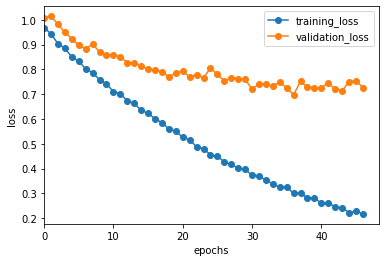

In [ ]:
plt.plot(history.epoch, history.history['loss'], '-o', label='training_loss')
plt.plot(history.epoch, history.history['val_loss'], '-o', label='validation_loss')
plt.legend()
plt.xlim(left=0)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [3]:
x_test = pd.read_pickle('drive/My Drive/data/x_test_mel-spectogram.pickle')
source_test = x_test.values

x_nor_test = list((map(normalize,source_test)))
x_nor_test = np.array(x_nor_test)
x_nor_test = x_nor_test.reshape(10000,126,-1,1)

x_test = Upscaling(x_nor_test, (299,299,1))

100%|██████████| 10000/10000 [00:02<00:00, 4058.77it/s]


In [7]:
# 가장 좋은 모델의 weight를 불러옵니다.
input_shape = (299,299,1)
model = inception_model(input_shape)
#weight_file = glob('drive/My Drive/data/model_inception_mel_spec/*.hdf5')[-1]
weight_file = 'drive/My Drive/data/model_inception_mel_spec/epoch_011_val_0.786981.hdf5'
print(weight_file)
model.load_weights(weight_file)

# 예측 수행
y_pred = model.predict(x_test)

# 예측 결과로 제출 파일을 생성합니다.
submission = pd.read_csv('drive/My Drive/data/submission.csv', index_col=0)
submission.loc[:, :] = y_pred
submission.to_csv('drive/My Drive/data/submission.csv')

drive/My Drive/data/model_inception_mel_spec/epoch_011_val_0.786981.hdf5


# 7/25
--------------------------------------

**모델** : epoch_003_val_**0.948952**.hdf5(2D model_inception_melspec)
  
**데이터**: x_trian_mel-spectogram
  
**score** : **1.01173**

--------------------------------------

# 7/26
--------------------------------------

**모델** : epoch_019_val_**0.887527**.hdf5(2D model_inception_melspec)
  
**데이터**: x_trian_mel-spectogram
  
**score** : **1.00909**

--------------------------------------

# 7/27
--------------------------------------

**모델** : epoch_037_val_**0.698013**.hdf5(2D model_inception_melspec)
  
**데이터**: x_trian_mel-spectogram
  
**score** : **1.0530194749**

--------------------------------------


# 7/28
--------------------------------------

**모델** : epoch_011_val_**0.786981**.hdf5(2D model_inception_melspec)
  
**데이터**: x_trian_mel-spectogram
  
**score** : **0.90709**

**메모** : data augmentation, random split으로 스코어 크게 개선됨

**피드백** : 강한 regulization으로 overfit 방지 필요

--------------------------------------